In [1]:
# --------- import required functions

from tensorflow.keras.layers import *
import pandas as pd



from tensorflow.keras.layers import *
from glob import glob
from keras import backend as K
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from keras.preprocessing.image import ImageDataGenerator
import os
import cv2
import numpy as np
from tensorflow.keras.utils import CustomObjectScope

from skimage.measure import label, regionprops

In [2]:
# -------------dice and dice_loss 
def dice_coef(y_true, y_pred, smooth=1):
    y_true = K.cast(y_true, 'float64')
    y_pred = K.cast(y_pred, 'float64')
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union        = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice         = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return dice

def dice_loss(y_true, y_pred):
  return 1.-dice_coef(y_true, y_pred)


# ----------build_unet  
class CONV:
    def conv_block(data, base, batchnorm=False):
        # --------------- 1st block
        x = Conv2D(filters=base, kernel_size=(3, 3), padding='same')(data)
        if batchnorm:
            x = BatchNormalization()(x)
        x = Activation("relu")(x)
        # --------------- 2nd block
        x = Conv2D(filters=base, kernel_size=(3, 3), padding='same')(x)
        if batchnorm:
            x = BatchNormalization()(x)
        x = Activation("relu")(x)
        return x

def build_unet(h, w, c, base, classes, dropout=True, batchnorm=True):
    num_filters = [base, base * 2, base * 4, base * 8]
    inputs = Input((h, w, c))

    skip_x = []
    x = inputs

    # ----------------- Encoder
    for f in num_filters:
        x = CONV.conv_block(x, f, batchnorm=True)
        skip_x.append(x)
        x = MaxPooling2D(pool_size=(2, 2), padding="same")(x)
        if dropout:
            x = Dropout(0.2)(x)

            # ----------------- Bridge
    x = CONV.conv_block(x, num_filters[-1], batchnorm=True)
    # x = MaxPooling2D(pool_size=(2, 2), padding="same") (x)  # no need to this layer
    if dropout:
        x = Dropout(0.2)(x)

    num_filters.reverse()
    skip_x.reverse()

    # ----------------- Decoder
    for i, f in enumerate(num_filters):
        #x = UpSampling2D((2, 2))(x)  # Conv2DTranspose(f, (2,2)) (x)
        x = Conv2DTranspose(filters=f, kernel_size=(3, 3), strides=(2, 2), padding='same')(x)
        xs = skip_x[i]
        #height, width = determine_crop(xs, x)
        #crop_xs = Cropping2D(cropping=(height, width))(xs)
        x = Concatenate()([x, xs])
        if dropout:
            x = Dropout(0.2)(x)
        x = CONV.conv_block(x, f, batchnorm=True)

    # ----------------- Output
    out = Conv2D(classes, (1, 1), padding="same", activation='sigmoid')(x)

    # ----------------- input and output
    model = Model(inputs=inputs, outputs=out)
    model.summary()
    return model





In [5]:
#modelFilePath = "/media/Tomasz/4T/work/keel/dataset/output/output_fold_1"
modelFilePath = "H:\\github\\deepLearning\\keel"
mainPath="I:\\download\\deepLearning\\datasets\\keelYolo\\keelTwoCalssesDataset"
#mainPath="/media/Tomasz/4T/work/keel/dataset"
#workDir = "imagesKeelBatch2/"
workDir = "onlyBatch2/"
outDir = "cutOffByMaskOutput/"
workPath = os.path.join(mainPath,workDir)
outPath = os.path.join(mainPath,outDir)

In [6]:
#model = tf.keras.models.load_model(os.path.join(modelFilePath, 'model.h5'), compile=False)
#model.compile()
lr = 0.0001
loss = "binary_crossentropy"
metrics = ["accuracy", tf.keras.metrics.Recall(), tf.keras.metrics.Precision(), dice_coef]
model = tf.keras.models.load_model(os.path.join(modelFilePath, 'model.h5'), compile=False)
model.compile(loss=loss,
                  optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  metrics=metrics)
#model = tf.keras.models.load_model(os.path.join(modelFilePath, 'model.h5'))

In [7]:
def image_normalization(img, img_min=0, img_max=255):
    """This is a typical image normalization function
    where the minimum and maximum of the image is needed
    source: https://en.wikipedia.org/wiki/Normalization_(image_processing)
    :param img: an image could be gray scale or color
    :param img_min:  for default is 0
    :param img_max: for default is 255
    :return: a normalized image, if max is 255 the dtype is uint8
    """
    img = np.float32(img)
    epsilon=1e-12 # whenever an inconsistent image
    img = (img-np.min(img))*(img_max-img_min)/((np.max(img)-np.min(img))+epsilon)+img_min
    return img

(2260, 1748)


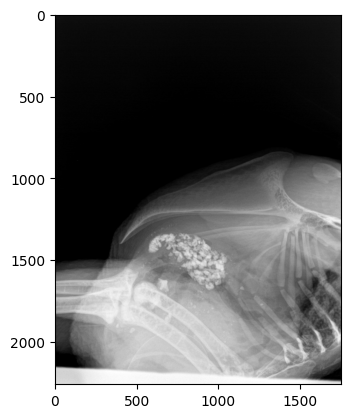

In [8]:

input_path = os.path.join(workPath, "02023SG1018_batch2_brown_ok_2.jpg")
input_path = os.path.join(workPath, "02023SG1005_batch2_brown_ok_0.jpg")

imageOne = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
print(imageOne.shape)
plt.imshow(imageOne, cmap="gray")


1/1 [==============================] - 25s 25s/step


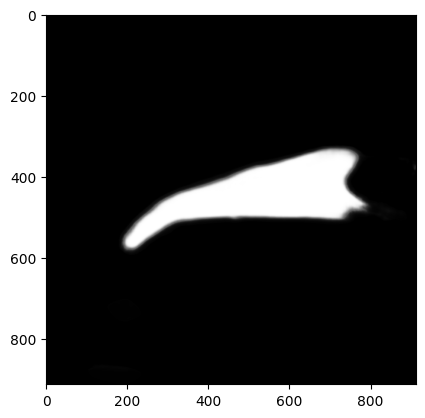

In [9]:

n=0
#for z in dataset_:
   # n=n+1
#input_path = os.path.join(workPath, "edged_02023SG3_batch2_brown_ok_0.jpg")
image=imageOne
image = image/255.0 # normalization
image = image.astype(np.float32)
image = cv2.resize(image, (912,912))
image = np.expand_dims(image, axis=0)
#plt.imshow(image)

res_pre = model.predict(image)
res = res_pre[-1,:,:]
#res *= 255.0
plt.imshow(res,cmap="gray")
    #fullpath = os.path.join(outPath, 'masked_'+str(n))
    #cv2.imwrite(fullpath, res_pre)


Found bbox (333, 193, 578, 787)   61110.0


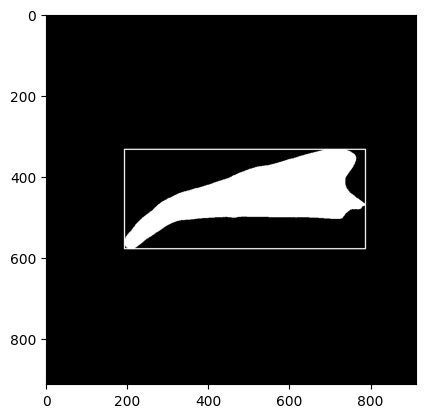

In [10]:

# from skimage.morphology import label
res2=image_normalization(res)
res2[res2 < 0.0] = 0.0
#out=cv2.bitwise_not(np.uint8(image_normalization(res2)))


mask_0 = res2
thresh = 127
mask_0 = cv2.threshold(mask_0, thresh, 255, cv2.THRESH_BINARY)[1]
mask_1 = mask_0
lbl_0 = label(mask_1) 
props = regionprops(lbl_0)
p=0
maxArea=-99999
maxIndex=0
x=y=w=h=0
for prop in props:
    print('Found bbox', prop.bbox, " ", prop.area)
    if(prop.area>maxArea):
        maxArea = prop.area
        maxIndex = p


    p=p+1
x = props[maxIndex].bbox[1]
y = props[maxIndex].bbox[0]
w = props[maxIndex].bbox[3]
h = props[maxIndex].bbox[2]
cv2.rectangle(mask_0, (x, y), (w, h), (255, 0, 0), 2)
plt.imshow(mask_0, cmap="gray")

cv2.rectangle(mask_0, (x, y), (w, h), (0, 0, 0), 2)
onlyMaskImage = mask_0[y:h, x:w]



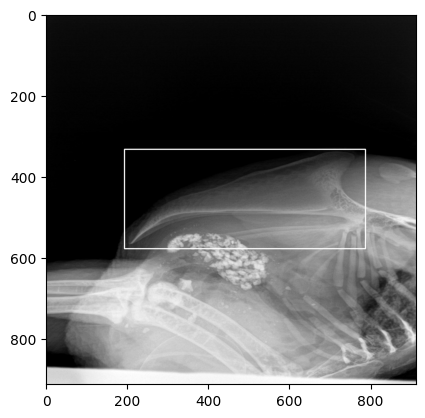

In [11]:
imageOneResized = cv2.resize(imageOne, (912,912))

cv2.rectangle(imageOneResized, (x, y), (w, h), (255, 0, 0), 2)
plt.imshow(imageOneResized, cmap="gray")

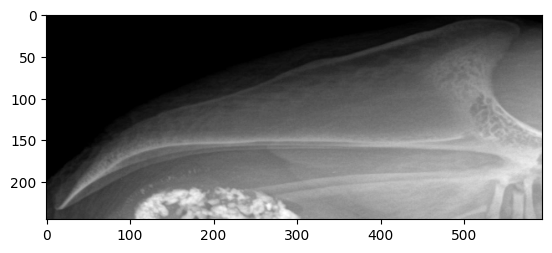

In [12]:
imageOneResized = cv2.resize(imageOne, (912,912))
onlyKeelImage = imageOneResized[y:h, x:w]
plt.imshow(onlyKeelImage, cmap="gray")

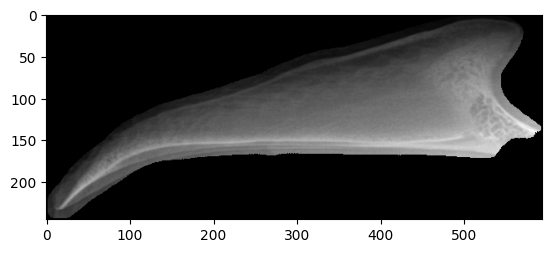

In [13]:
#masked = cv2.bitwise_and(np.array(onlyKeelImage), np.array(onlyMaskImage))
masked = np.array(onlyKeelImage) * np.array(onlyMaskImage/255)
plt.imshow(masked, cmap="gray")


In [14]:
fullpath = os.path.join(outPath, "2.jpg")
cv2.imwrite(fullpath, masked)

True

In [15]:
def predict_mask(image_in):
    image=image_in
    image = image/255.0 # normalization
    image = image.astype(np.float32)
    image = cv2.resize(image, (912,912))
    image = np.expand_dims(image, axis=0)
    res_pre = model.predict(image)
    res = res_pre[-1,:,:]
    return res

def get_rectangle_with_bigest_mask(mask_in):
    res2=image_normalization(mask_in)
    res2[res2 < 0.0] = 0.0
    mask_0 = res2
    thresh = 127
    mask_0 = cv2.threshold(mask_0, thresh, 255, cv2.THRESH_BINARY)[1]
    mask_1 = mask_0
    lbl_0 = label(mask_1) 
    props = regionprops(lbl_0)
    p=0
    maxArea=-99999
    maxIndex=0
    x=y=w=h=0
    
    for prop in props:
        #print('Found bbox', prop.bbox, " ", prop.area)
        if(prop.area>maxArea):
            maxArea = prop.area
            maxIndex = p


        p=p+1
        
    x = props[maxIndex].bbox[1]
    y = props[maxIndex].bbox[0]
    w = props[maxIndex].bbox[3]
    h = props[maxIndex].bbox[2]

    onlyMaskImage = mask_0[y:h, x:w]
    
    return x,y,w,h,onlyMaskImage
    
def get_rectangle_from_original_image(x,y,w,h,imageOne,iw,ih):
    imageOneResized = cv2.resize(imageOne, (iw,ih))
    onlyKeelImage = imageOneResized[y:h, x:w]

    return onlyKeelImage

In [17]:
imageList = glob(os.path.join(workPath,"*"))
for n in range(len(imageList)):
    input_path = imageList[n]
    filename = os.path.basename(imageList[n])
    imageOne = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)

    predicted_mask = predict_mask(imageOne)


    x,y,w,h,mask_rect = get_rectangle_with_bigest_mask(predicted_mask)
    print(x,y,w,h)
    predicted_keel = get_rectangle_from_original_image(x,y,w,h,imageOne,912,912)
    #plt.imshow(predicted_mask)
    #out = np.array(predicted_keel) * np.array(mask_rect/255)
    fullpath = os.path.join(outPath, filename)
    cv2.imwrite(fullpath, predicted_keel)


1/1 [==============================] - 0s 36ms/step
193 333 787 578
1/1 [==============================] - 0s 32ms/step
170 391 753 619
1/1 [==============================] - 0s 33ms/step
170 205 794 394
1/1 [==============================] - 0s 37ms/step
144 335 719 523
1/1 [==============================] - 0s 56ms/step
183 105 859 347
1/1 [==============================] - 0s 75ms/step
187 114 823 319
1/1 [==============================] - 0s 34ms/step
194 371 799 595
1/1 [==============================] - 0s 32ms/step
173 377 828 557
1/1 [==============================] - 0s 32ms/step
204 86 871 273
1/1 [==============================] - 0s 29ms/step
188 127 826 332
1/1 [==============================] - 0s 37ms/step
274 197 876 397
1/1 [==============================] - 0s 27ms/step
174 311 834 491
1/1 [==============================] - 0s 33ms/step
198 310 875 528
1/1 [==============================] - 0s 68ms/step
212 132 892 371
1/1 [==============================] - 0s 28ms/st

250 159 876 344
1/1 [==============================] - 0s 33ms/step
222 163 865 438
1/1 [==============================] - 0s 30ms/step
190 372 778 530
1/1 [==============================] - 0s 29ms/step
212 87 912 398
1/1 [==============================] - 0s 29ms/step
220 176 840 459
1/1 [==============================] - 0s 32ms/step
204 111 912 311
1/1 [==============================] - 0s 31ms/step
239 145 870 436
1/1 [==============================] - 0s 29ms/step
215 141 873 347
1/1 [==============================] - 0s 34ms/step
213 114 844 298
1/1 [==============================] - 0s 28ms/step
234 161 904 363
1/1 [==============================] - 0s 37ms/step
204 132 850 389
1/1 [==============================] - 0s 29ms/step
165 347 761 550
1/1 [==============================] - 0s 30ms/step
189 363 834 540
1/1 [==============================] - 0s 33ms/step
240 393 857 584
1/1 [==============================] - 0s 36ms/step
222 359 815 555
1/1 [============================

1/1 [==============================] - 0s 30ms/step
151 310 857 553
1/1 [==============================] - 0s 31ms/step
203 265 846 596
1/1 [==============================] - 0s 29ms/step
238 352 832 539
1/1 [==============================] - 0s 29ms/step
136 167 792 377
1/1 [==============================] - 0s 28ms/step
154 209 764 433
1/1 [==============================] - 0s 30ms/step
204 274 825 613
1/1 [==============================] - 0s 31ms/step
375 540 419 550
1/1 [==============================] - 0s 29ms/step
132 329 752 539
1/1 [==============================] - 0s 30ms/step
154 138 819 329
1/1 [==============================] - 0s 29ms/step
137 292 786 524
1/1 [==============================] - 0s 29ms/step
147 163 770 353
1/1 [==============================] - 0s 30ms/step
185 318 816 495
1/1 [==============================] - 0s 30ms/step
621 349 669 359
1/1 [==============================] - 0s 29ms/step
134 280 746 520
1/1 [==============================] - 0s 30ms/s

260 204 837 380
1/1 [==============================] - 0s 30ms/step
180 342 794 532
1/1 [==============================] - 0s 31ms/step
219 173 777 504
1/1 [==============================] - 0s 29ms/step
105 338 715 601
1/1 [==============================] - 0s 28ms/step
182 373 808 584
1/1 [==============================] - 0s 36ms/step
186 175 771 500
1/1 [==============================] - 0s 29ms/step
145 107 805 394
1/1 [==============================] - 0s 29ms/step
202 338 807 504
1/1 [==============================] - 0s 28ms/step
114 316 764 508
1/1 [==============================] - 0s 28ms/step
152 362 736 577
1/1 [==============================] - 0s 30ms/step
233 185 840 492
1/1 [==============================] - 0s 29ms/step
173 153 798 393
1/1 [==============================] - 0s 35ms/step
216 283 837 503
1/1 [==============================] - 0s 29ms/step
148 18 755 221
1/1 [==============================] - 0s 29ms/step
93 254 743 481
1/1 [=============================

1/1 [==============================] - 0s 29ms/step
249 150 908 382
1/1 [==============================] - 0s 29ms/step
261 147 912 372
1/1 [==============================] - 0s 28ms/step
141 252 777 440
1/1 [==============================] - 0s 28ms/step
204 150 832 445
1/1 [==============================] - 0s 30ms/step
139 127 810 321
1/1 [==============================] - 0s 30ms/step
129 142 814 457
1/1 [==============================] - 0s 28ms/step
199 175 815 343
1/1 [==============================] - 0s 30ms/step
238 162 862 433
1/1 [==============================] - 0s 28ms/step
236 137 790 364
1/1 [==============================] - 0s 34ms/step
230 150 845 390
1/1 [==============================] - 0s 29ms/step
130 107 815 323
1/1 [==============================] - 0s 29ms/step
142 132 837 369
1/1 [==============================] - 0s 29ms/step
216 188 894 409
1/1 [==============================] - 0s 29ms/step
149 361 761 590
1/1 [==============================] - 0s 29ms/s

1/1 [==============================] - 0s 32ms/step
225 365 763 503
1/1 [==============================] - 0s 28ms/step
238 409 746 530
1/1 [==============================] - 0s 29ms/step
196 414 705 587
1/1 [==============================] - 0s 28ms/step
260 444 738 572
1/1 [==============================] - 0s 29ms/step
299 333 826 490
1/1 [==============================] - 0s 29ms/step
220 343 759 482
1/1 [==============================] - 0s 38ms/step
244 430 747 547
1/1 [==============================] - 0s 30ms/step
245 387 781 527
1/1 [==============================] - 0s 32ms/step
138 339 706 525
1/1 [==============================] - 0s 30ms/step
230 404 737 527
1/1 [==============================] - 0s 28ms/step
170 370 691 505
1/1 [==============================] - 0s 29ms/step
184 403 714 543
1/1 [==============================] - 0s 29ms/step
232 405 720 544
1/1 [==============================] - 0s 30ms/step
202 472 712 588
1/1 [==============================] - 0s 33ms/s

1/1 [==============================] - 0s 31ms/step
207 399 739 542
1/1 [==============================] - 0s 28ms/step
216 366 744 495
1/1 [==============================] - 0s 29ms/step
169 406 767 532
1/1 [==============================] - 0s 28ms/step
213 332 781 477
1/1 [==============================] - 0s 29ms/step
244 326 783 457
1/1 [==============================] - 0s 30ms/step
206 415 759 544
1/1 [==============================] - 0s 28ms/step
194 356 715 481
1/1 [==============================] - 0s 29ms/step
229 417 731 551
1/1 [==============================] - 0s 29ms/step
277 416 783 539
1/1 [==============================] - 0s 29ms/step
247 428 911 587
1/1 [==============================] - 0s 29ms/step
223 361 742 493
1/1 [==============================] - 0s 29ms/step
232 401 755 553
1/1 [==============================] - 0s 30ms/step
160 403 813 541
1/1 [==============================] - 0s 30ms/step
222 365 825 486
1/1 [==============================] - 0s 31ms/s

1/1 [==============================] - 0s 31ms/step
158 358 687 498
1/1 [==============================] - 0s 42ms/step
279 408 793 538
1/1 [==============================] - 0s 30ms/step
204 500 684 628
1/1 [==============================] - 0s 28ms/step
219 380 733 508
1/1 [==============================] - 0s 31ms/step
214 424 777 558
1/1 [==============================] - 0s 32ms/step
266 392 789 519
1/1 [==============================] - 0s 29ms/step
224 449 672 617
1/1 [==============================] - 0s 28ms/step
196 383 707 511
1/1 [==============================] - 0s 34ms/step
188 360 710 523
1/1 [==============================] - 0s 28ms/step
196 357 760 522
1/1 [==============================] - 0s 28ms/step
224 387 769 518
1/1 [==============================] - 0s 50ms/step
159 368 682 519
1/1 [==============================] - 0s 33ms/step
170 437 633 606
1/1 [==============================] - 0s 33ms/step
234 407 737 527
1/1 [==============================] - 0s 30ms/s

1/1 [==============================] - 0s 29ms/step
168 356 692 515
1/1 [==============================] - 0s 30ms/step
235 399 715 520
1/1 [==============================] - 0s 33ms/step
204 339 713 487
1/1 [==============================] - 0s 32ms/step
214 432 719 564
1/1 [==============================] - 0s 28ms/step
193 376 726 505
1/1 [==============================] - 0s 29ms/step
154 419 653 540
1/1 [==============================] - 0s 29ms/step
188 404 722 533
1/1 [==============================] - 0s 29ms/step
235 397 755 513
1/1 [==============================] - 0s 28ms/step
184 456 807 588
1/1 [==============================] - 0s 48ms/step
184 379 737 541
1/1 [==============================] - 0s 30ms/step
228 395 757 544
1/1 [==============================] - 0s 29ms/step
220 409 776 551
1/1 [==============================] - 0s 29ms/step
193 463 774 593
1/1 [==============================] - 0s 28ms/step
189 361 733 514
1/1 [==============================] - 0s 29ms/s

1/1 [==============================] - 0s 27ms/step
217 115 912 337
1/1 [==============================] - 0s 32ms/step
187 93 787 291
1/1 [==============================] - 0s 29ms/step
196 53 846 259
1/1 [==============================] - 0s 32ms/step
194 84 912 300
1/1 [==============================] - 0s 107ms/step
202 69 846 311
1/1 [==============================] - 0s 31ms/step
229 58 852 248
1/1 [==============================] - 0s 29ms/step
230 95 837 263
1/1 [==============================] - 0s 90ms/step
200 193 912 368
1/1 [==============================] - 0s 28ms/step
200 171 912 334
1/1 [==============================] - 0s 31ms/step
56 178 912 380
1/1 [==============================] - 0s 35ms/step
210 107 903 297
1/1 [==============================] - 0s 32ms/step
180 31 827 215
1/1 [==============================] - 0s 50ms/step
86 49 813 345
1/1 [==============================] - 0s 37ms/step
97 193 756 408
1/1 [==============================] - 0s 49ms/step
153 18

1/1 [==============================] - 0s 29ms/step
208 48 853 247
1/1 [==============================] - 0s 29ms/step
202 76 912 267
1/1 [==============================] - 0s 33ms/step
120 373 619 513
1/1 [==============================] - 0s 29ms/step
115 431 631 585
1/1 [==============================] - 0s 27ms/step
145 127 821 382
1/1 [==============================] - 0s 28ms/step
107 48 851 294
1/1 [==============================] - 0s 29ms/step
225 470 724 611
1/1 [==============================] - 0s 31ms/step
137 112 809 399
1/1 [==============================] - 0s 27ms/step
191 99 912 282
1/1 [==============================] - 0s 30ms/step
217 65 812 273
1/1 [==============================] - 0s 29ms/step
296 474 808 637
1/1 [==============================] - 0s 34ms/step
252 115 838 299
1/1 [==============================] - 0s 42ms/step
117 75 861 314
1/1 [==============================] - 0s 34ms/step
189 67 840 237
1/1 [==============================] - 0s 27ms/step
216

1/1 [==============================] - 0s 31ms/step
146 397 738 545
1/1 [==============================] - 0s 64ms/step
176 330 731 483
1/1 [==============================] - 0s 47ms/step
166 381 752 534
1/1 [==============================] - 0s 30ms/step
156 337 703 477
1/1 [==============================] - 0s 29ms/step
135 341 684 504
1/1 [==============================] - 0s 35ms/step
220 172 744 314
1/1 [==============================] - 0s 36ms/step
254 196 798 339
1/1 [==============================] - 0s 29ms/step
136 355 681 488
1/1 [==============================] - 0s 30ms/step
168 361 713 501
1/1 [==============================] - 0s 33ms/step
174 372 745 532
1/1 [==============================] - 0s 32ms/step
270 383 746 542
1/1 [==============================] - 0s 29ms/step
183 42 777 231
1/1 [==============================] - 0s 27ms/step
181 364 700 489
1/1 [==============================] - 0s 34ms/step
128 402 693 542
1/1 [==============================] - 0s 28ms/st

202 406 766 548
1/1 [==============================] - 0s 29ms/step
261 373 698 509
1/1 [==============================] - 0s 28ms/step
228 306 782 454
1/1 [==============================] - 0s 45ms/step
187 52 759 202
1/1 [==============================] - 0s 32ms/step
140 407 768 557
1/1 [==============================] - 0s 27ms/step
170 348 742 496
1/1 [==============================] - 0s 28ms/step
380 189 736 332
1/1 [==============================] - 0s 30ms/step
191 50 767 202
1/1 [==============================] - 0s 31ms/step
178 403 722 536
1/1 [==============================] - 0s 31ms/step
192 371 738 506
1/1 [==============================] - 0s 27ms/step
158 425 733 574
1/1 [==============================] - 0s 53ms/step
229 396 753 532
1/1 [==============================] - 0s 32ms/step
211 397 754 529
1/1 [==============================] - 0s 28ms/step
109 369 672 505
1/1 [==============================] - 0s 28ms/step
189 356 714 497
1/1 [=============================

1/1 [==============================] - 0s 31ms/step
178 407 703 556
1/1 [==============================] - 0s 29ms/step
281 143 698 284
1/1 [==============================] - 0s 28ms/step
154 410 691 544
1/1 [==============================] - 0s 32ms/step
185 419 719 562
1/1 [==============================] - 0s 30ms/step
191 338 781 496
1/1 [==============================] - 0s 28ms/step
213 185 738 307
1/1 [==============================] - 0s 27ms/step
208 156 709 292
1/1 [==============================] - 0s 32ms/step
143 419 737 565
1/1 [==============================] - 0s 100ms/step
172 337 687 468
1/1 [==============================] - 0s 28ms/step
232 180 715 303
1/1 [==============================] - 0s 38ms/step
219 395 733 526
1/1 [==============================] - 0s 28ms/step
296 177 721 304
1/1 [==============================] - 0s 30ms/step
208 157 715 291
1/1 [==============================] - 0s 28ms/step
165 389 714 529
1/1 [==============================] - 0s 28ms/

1/1 [==============================] - 0s 29ms/step
148 57 745 233
1/1 [==============================] - 0s 27ms/step
159 416 725 556
1/1 [==============================] - 0s 28ms/step
91 374 621 500
1/1 [==============================] - 0s 29ms/step
144 413 715 564
1/1 [==============================] - 0s 31ms/step
152 401 693 553
1/1 [==============================] - 0s 28ms/step
156 87 752 252
1/1 [==============================] - 0s 29ms/step
121 357 650 541
1/1 [==============================] - 0s 37ms/step
216 181 740 337
1/1 [==============================] - 0s 28ms/step
181 361 725 506
1/1 [==============================] - 0s 36ms/step
234 178 743 311
1/1 [==============================] - 0s 29ms/step
224 181 727 313
1/1 [==============================] - 0s 31ms/step
119 335 657 475
1/1 [==============================] - 0s 28ms/step
187 365 761 519
1/1 [==============================] - 0s 28ms/step
185 156 693 308
1/1 [==============================] - 0s 28ms/step